# **Part 1: ETL Process for Branch, Customer, Credit, and Loan Data**

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [ ]:
spark = SparkSession\
    .builder\
    .config("spark.jars", "/Users/nahidrahman/opt/miniconda3/lib/python3.9/site-packages/pyspark/jars/mysql-connector-j-8.0.31.jar")\
    .appName("creditcard")\
    .getOrCreate()

## Creating the database

In [ ]:
import mysql.connector

mydb = mysql.connector.connect(
  host="localhost",
  user="****",
  password="****"
)
mycursor = mydb.cursor()
mycursor.execute("CREATE DATABASE creditcard_capstone")

## EXTRACT

Loading provided JSON files for the branch, customer, and credit data and creating Pyspark dataframes

In [3]:
df_branch = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_branch.json")

df_customer = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_customer.json")

df_credit = spark.read.format("json") \
    .option("header", True) \
    .load("cdw_sapp_credit.json")

Using GET Request on an API endpoint on loan data

In [4]:
import requests
import json

In [5]:
api_url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(api_url)

In [6]:
response.status_code

200

Creating dataframe on the loan data

In [7]:
cdw_sapp_loan = response.json()
df_loan = spark.createDataFrame(cdw_sapp_loan)

In [ ]:
with open('cdw_sapp_loan.json', 'w') as out_file:
     json.dump(cdw_sapp_loan, out_file)
#creates a json file for the loan data 

Printing schemas of the dataframes 

In [8]:
dataframe_dict = {}

dataframe_dict['branch'] = df_branch  # assign val to dict
dataframe_dict['customer'] = df_customer
dataframe_dict['credit'] = df_credit
dataframe_dict['loan'] = df_loan

In [9]:
for name, dataframe in dataframe_dict.items():  # k:v in (k, v)
    print(name)
    dataframe.printSchema()

branch
root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: long (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)

customer
root
 |-- APT_NO: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: long (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: string (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- STREET_NAME: string (nullable = true)

credit
root
 |-- BRANCH_CODE: long (nullable = tr

Displaying the dataframes

In [10]:
df_branch.show(3)

+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
only showing top 3 rows



In [11]:
df_customer.show(3)

+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|        LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+-------------------+----------+----------+--------+----------+---------+--------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|   1237818|        MS|   39120|      Alec|   Hooper|2018-04-21T12:49:...|         Wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|   1238933|        CT|   06109|      Etta|   Holman|2018-04-21T12:49:...|    Brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States|WDunham@example.co

In [12]:
df_credit.show(3)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
only showing top 3 rows



In [13]:
df_loan.show(3)

+--------------+------------------+--------------+----------+---------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+---------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0| Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1| Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0| Graduate|  Male|   low|    Yes|        Urban|          Yes|
+--------------+------------------+--------------+----------+---------+------+------+-------+-------------+-------------+
only showing top 3 rows



## TRANSFORM

We were given a mapping document for each dataframe that show what transformations need be done.

### Tranform Branch dataframe

Here is the mapping document for the branch data frame

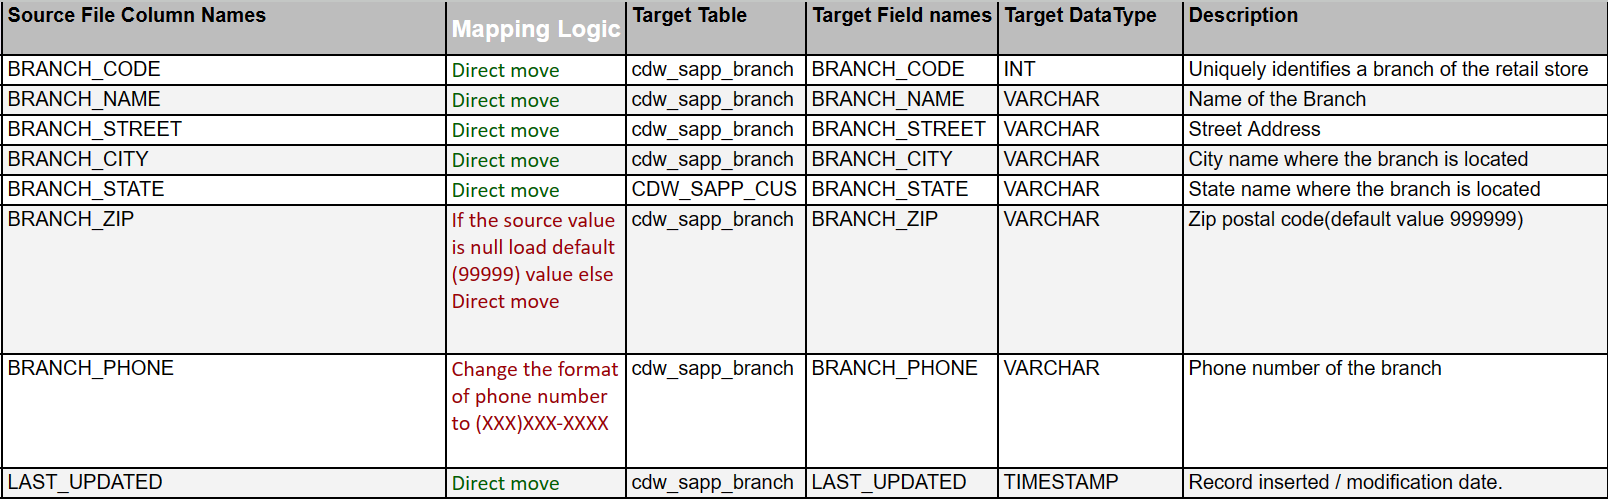

From the mapping document, we have to make transformations to the BRANCH_PHONE, BRANCH_ZIP, and LAST_UPDATED columns.

BRANCH_PHONE
-  change the format to (XXX)-XXX-XXXX 

BRANCH_ZIP
- fill in null values
- change data type from int to string

LAST_UPDATED
- change the datatype from string to timestamp

**Transforming BRANCH_PHONE column**

In [14]:
df_branch[['BRANCH_PHONE']].show(3)

+------------+
|BRANCH_PHONE|
+------------+
|  1234565276|
|  1234618993|
|  1234985926|
+------------+
only showing top 3 rows



In [12]:
from pyspark.sql import functions as F

In [16]:
branch_phone_refactor= F.udf(lambda phone_number: "(" + phone_number[:3] + ")" + phone_number[3:6] + "-" + phone_number[6:])
df_branch = df_branch.withColumn('BRANCH_PHONE', branch_phone_refactor(df_branch['BRANCH_PHONE']))

In [17]:
df_branch[['BRANCH_PHONE']].show(3)

+-------------+
| BRANCH_PHONE|
+-------------+
|(123)456-5276|
|(123)461-8993|
|(123)498-5926|
+-------------+
only showing top 3 rows



**Transforming BRANCH_ZIP column**

I don't think there are any null values but lets check anyway

In [18]:
df_branch[['BRANCH_ZIP']].createOrReplaceGlobalTempView('zip')

In [19]:
spark.sql("select * from global_temp.zip where branch_zip = null").show()

+----------+
|BRANCH_ZIP|
+----------+
+----------+



There are no null values, as shown above but the code below would replace all of them with "99999"

In [20]:
df_branch = df_branch.fillna({'BRANCH_ZIP':99999})

In [21]:
df_branch = df_branch.withColumns({'BRANCH_ZIP':df_branch['BRANCH_ZIP'].cast('string')})

**Transforming LAST_UPDATED column**

In [22]:
df_branch = df_branch.withColumns({'LAST_UPDATED':df_branch['LAST_UPDATED'].cast('timestamp')})


In [23]:
df_branch.printSchema()

root
 |-- BRANCH_CITY: string (nullable = true)
 |-- BRANCH_CODE: long (nullable = true)
 |-- BRANCH_NAME: string (nullable = true)
 |-- BRANCH_PHONE: string (nullable = true)
 |-- BRANCH_STATE: string (nullable = true)
 |-- BRANCH_STREET: string (nullable = true)
 |-- BRANCH_ZIP: string (nullable = false)
 |-- LAST_UPDATED: timestamp (nullable = true)



In [24]:
df_branch.show(5)

+-----------------+-----------+------------+-------------+------------+-----------------+----------+-------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME| BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|       LAST_UPDATED|
+-----------------+-----------+------------+-------------+------------+-----------------+----------+-------------------+
|        Lakeville|          1|Example Bank|(123)456-5276|          MN|     Bridle Court|     55044|2018-04-18 16:51:47|
|          Huntley|          2|Example Bank|(123)461-8993|          IL|Washington Street|     60142|2018-04-18 16:51:47|
|SouthRichmondHill|          3|Example Bank|(123)498-5926|          NY|    Warren Street|     11419|2018-04-18 16:51:47|
|       Middleburg|          4|Example Bank|(123)466-3064|          FL| Cleveland Street|     32068|2018-04-18 16:51:47|
|    KingOfPrussia|          5|Example Bank|(123)484-9701|          PA|      14th Street|     19406|2018-04-18 16:51:47|
+-----------------+-----------+-

### Transform Customer dataframe

Here is the mapping document for the customer data frame

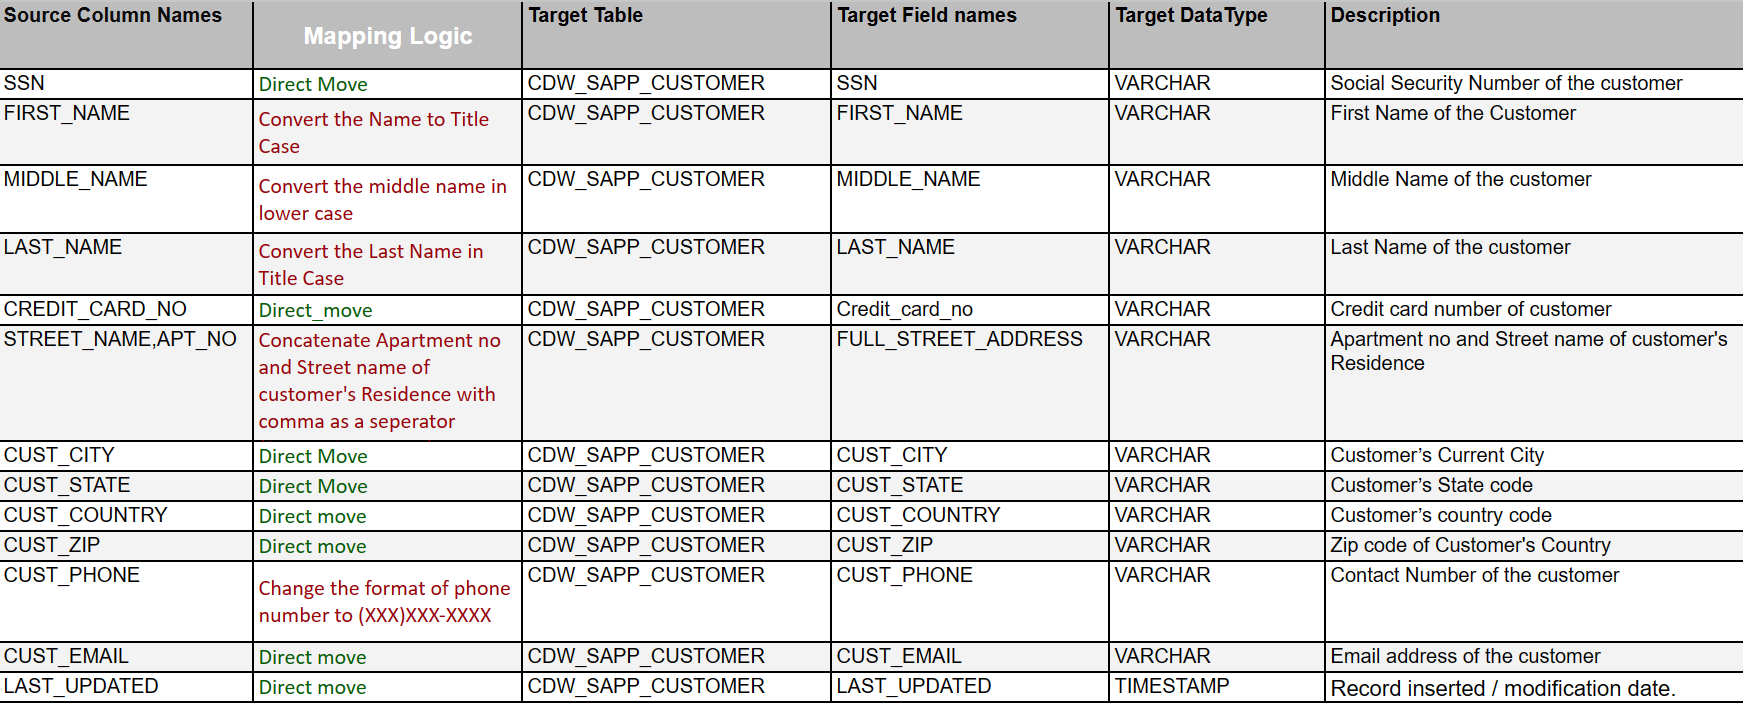

From the mapping document, we have to make transformations to the FIRST_NAME, MIDDLE_NAME, LAST_NAME, STREET_NAME, APT_NO, CUST_PHONE, and LAST_UPDATED columns

FIRST_NAME and LAST_NAME
- convert to Title Case 

MIDDLE_NAME
- convert to lower case

STREET_NAME, APT_NO 
- concatenate with a comma as separator

CUST_PHONE 
- change format to (XXX)XXX-XXXX

LAST_UPDATED
- convert data type from string to timestamp

**Transforming FIRST_NAME, MIDDLE_NAME and LAST_NAME columns**

In [5]:
df_customer["FIRST_NAME","MIDDLE_NAME","LAST_NAME"].show(3)

+----------+-----------+---------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|
+----------+-----------+---------+
|      Alec|         Wm|   Hooper|
|      Etta|    Brendan|   Holman|
|    Wilber|   Ezequiel|   Dunham|
+----------+-----------+---------+
only showing top 3 rows



In [13]:
df_customer = df_customer.withColumn("FIRST_NAME", F.initcap(df_customer["FIRST_NAME"])) \
            .withColumn("LAST_NAME", F.initcap(df_customer["LAST_NAME"])) \
            .withColumn("MIDDLE_NAME", F.lower(df_customer["MIDDLE_NAME"]))

In [27]:
df_customer["FIRST_NAME","MIDDLE_NAME","LAST_NAME"].show(3)

+----------+-----------+---------+
|FIRST_NAME|MIDDLE_NAME|LAST_NAME|
+----------+-----------+---------+
|      Alec|         wm|   Hooper|
|      Etta|    brendan|   Holman|
|    Wilber|   ezequiel|   Dunham|
+----------+-----------+---------+
only showing top 3 rows



**Transforming CUST_PHONE column**

In [10]:
df_customer[['CUST_PHONE']].show(3)

+----------+
|CUST_PHONE|
+----------+
|   1237818|
|   1238933|
|   1243018|
+----------+
only showing top 3 rows



In [14]:
phone_refactor = F.udf(lambda phone: "(555)" + str(phone)[:3] + "-" + str(phone)[3:])
# phone[0, 3) + phone[3:]
# note the slice includes the end of the string with [:]

In [15]:
df_customer = df_customer.withColumn('CUST_PHONE', phone_refactor(df_customer['CUST_PHONE']))

In [17]:
df_customer[['CUST_PHONE']].show(3)

+-------------+
|   CUST_PHONE|
+-------------+
|(555)123-7818|
|(555)123-8933|
|(555)124-3018|
+-------------+
only showing top 3 rows



23/11/13 02:01:44 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 425846 ms exceeds timeout 120000 ms
23/11/13 02:01:44 WARN SparkContext: Killing executors is not supported by current scheduler.
23/11/13 02:01:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

**Transforming the datatype of LAST_UPDATED column**

In [31]:
df_customer= df_customer.withColumn('LAST_UPDATED', df_customer['LAST_UPDATED'].cast('timestamp'))
df_customer[['LAST_UPDATED']].show(2, truncate=False)

+-------------------+
|LAST_UPDATED       |
+-------------------+
|2018-04-21 12:49:02|
|2018-04-21 12:49:02|
+-------------------+
only showing top 2 rows



In [32]:
df_customer.printSchema()

root
 |-- APT_NO: string (nullable = true)
 |-- CREDIT_CARD_NO: string (nullable = true)
 |-- CUST_CITY: string (nullable = true)
 |-- CUST_COUNTRY: string (nullable = true)
 |-- CUST_EMAIL: string (nullable = true)
 |-- CUST_PHONE: string (nullable = true)
 |-- CUST_STATE: string (nullable = true)
 |-- CUST_ZIP: string (nullable = true)
 |-- FIRST_NAME: string (nullable = true)
 |-- LAST_NAME: string (nullable = true)
 |-- LAST_UPDATED: timestamp (nullable = true)
 |-- MIDDLE_NAME: string (nullable = true)
 |-- SSN: long (nullable = true)
 |-- STREET_NAME: string (nullable = true)



**Updated customer data frame**

In [33]:
df_customer.show(3)

+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+
|APT_NO|  CREDIT_CARD_NO|   CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN|      STREET_NAME|
+------+----------------+------------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+-----------------+
|   656|4210653310061055|     Natchez|United States|AHooper@example.com|(555)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21 12:49:02|         wm|123456100|Main Street North|
|   829|4210653310102868|Wethersfield|United States|EHolman@example.com|(555)123-8933|        CT|   06109|      Etta|   Holman|2018-04-21 12:49:02|    brendan|123453023|    Redwood Drive|
|   683|4210653310116272|     Huntley|United States|WDunham@

### Transform the Credit Table

Here is the mapping document for the credit table

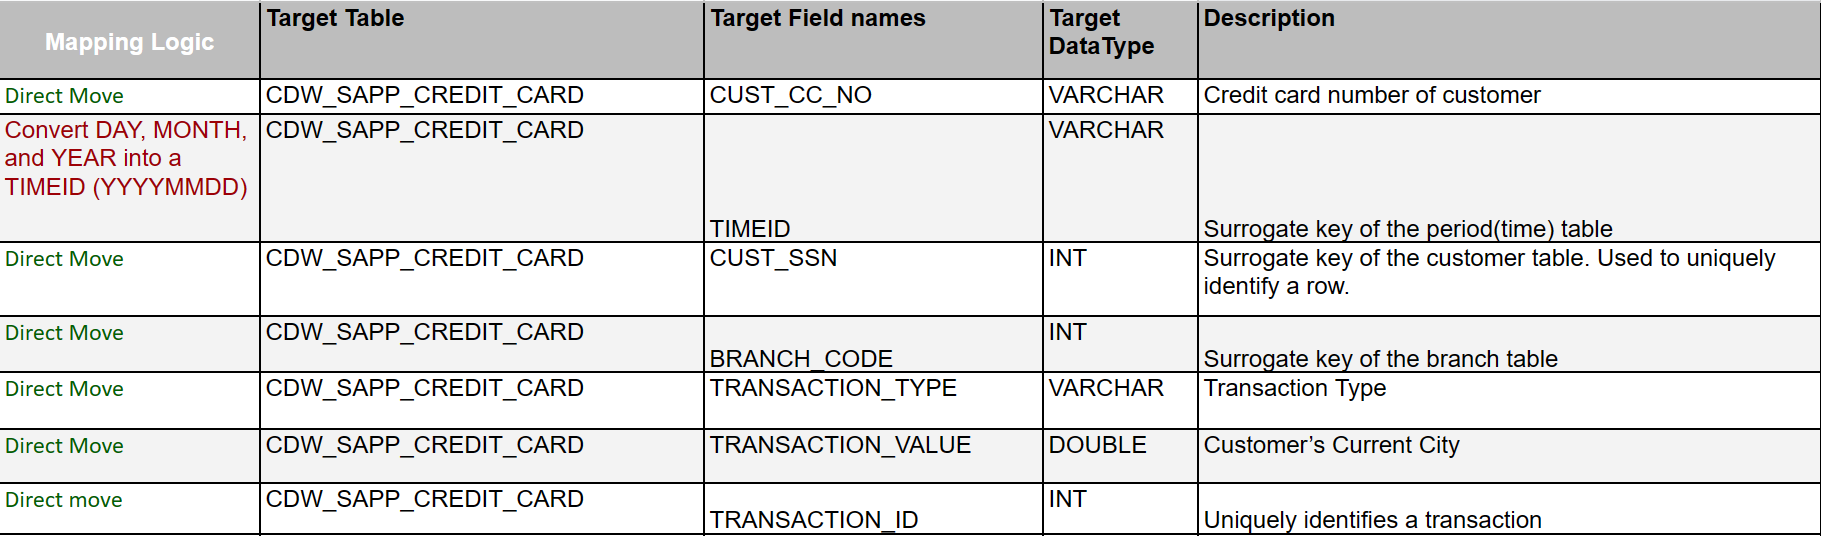

From this document, we only have to transform the DAY, MONTH, and YEAR columns
- Convert DAY, MONTH and YEAR into a TIMEID column (YYYYMMDD)


In [34]:
df_credit.show(3)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+
only showing top 3 rows



In [35]:
from pyspark.sql.functions import concat_ws, lpad

In [36]:
df_credit = df_credit.withColumn("TIMEID", concat_ws("", "YEAR", lpad("MONTH", 2, "0"), lpad("DAY", 2, "0")))

**Updated Branch dataframe**

In [37]:
df_credit.show(3)

+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|BRANCH_CODE|  CREDIT_CARD_NO| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|  TIMEID|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
|        114|4210653349028689|123459988| 14|    2|             1|       Education|             78.9|2018|20180214|
|         35|4210653349028689|123459988| 20|    3|             2|   Entertainment|            14.24|2018|20180320|
|        160|4210653349028689|123459988|  8|    7|             3|         Grocery|             56.7|2018|20180708|
+-----------+----------------+---------+---+-----+--------------+----------------+-----------------+----+--------+
only showing top 3 rows



## LOAD

Writing the branch, customer, credit, and loan dataframes into tables in the creditcard_capstone MySQL database

In [ ]:
df_branch.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
  .option("user", "root") \
  .option("password", "password") \
  .mode("overwrite")\
  .option("driver", 'com.mysql.jdbc.Driver')\
  .save()

In [ ]:
df_customer.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "creditcard_capstone.CDW_SAPP_customer") \
  .option("user", "root") \
  .option("password", "password") \
  .mode("overwrite")\
  .option("driver", 'com.mysql.jdbc.Driver')\
  .save()
"""
connects to the mysql database with:
local host as 3306
creditcard_capstone as database name
CDW_SAPP_CUSTOMER as table name
"""

In [40]:
df_credit.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT") \
          .option("user", "root") \
            .option("password", "password") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

In [41]:
df_loan.write.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_LOAN") \
          .option("user", "root") \
            .option("password", "password") \
            .mode("overwrite")\
            .option("driver", 'com.mysql.jdbc.Driver')\
            .save()

Here is a snapshot of the uploaded data in MySQL Workbench

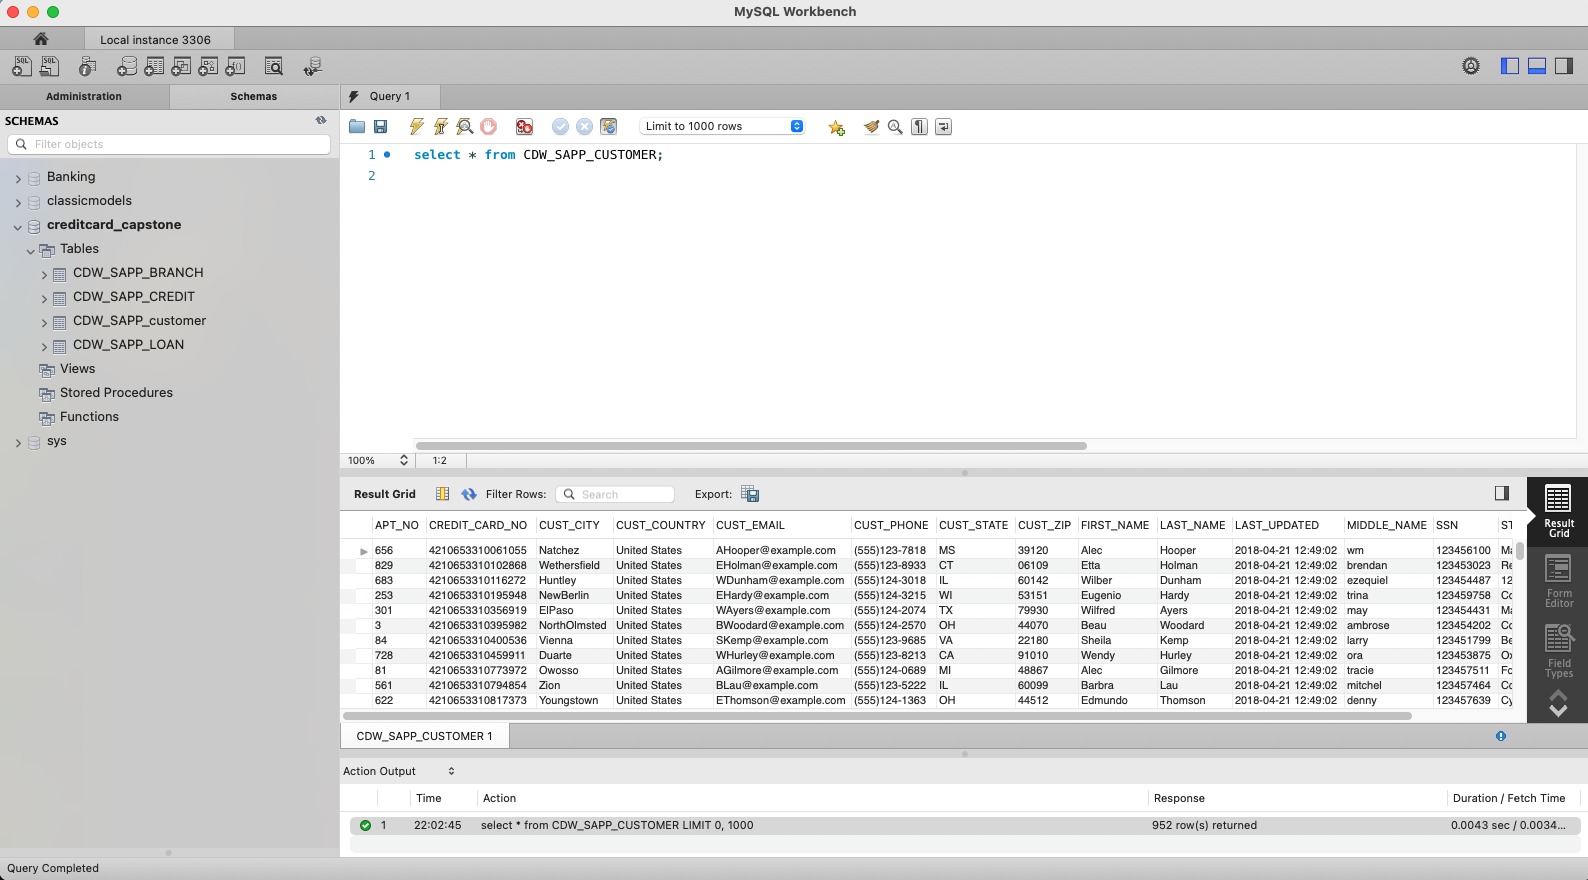

In [42]:
spark.stop()